## Athena ML Coding Exam <br>
#### notebook edition

In [1]:
import torch
import torch.nn.functional as F
from sklearn.metrics import brier_score_loss
from torch.utils.data import DataLoader
import numpy as np
import sys
import traceback
from datasets_cifar10 import train_dataset, test_dataset
# from datasets_subcifar10 import train_dataset, test_dataset

from model import Net


Files already downloaded and verified
Files already downloaded and verified
Model's state_dict:
conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([10, 84])
fc3.bias 	 torch.Size([10])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]


In [3]:
def compute_calibration_metrics(model, dataloader):
    ''' computes the calibration metrics for the loaded model against the chosen dataset.
        model's input shape and output shape needs to match provided dataset input shape and target set respectively.

    
    '''
    # Set model to evaluation mode
    model.eval()

    # Initialize variables to store calibration metrics
    num_samples = 0
    confidences = []
    accuracies = []

    # Iterate over the data loader and collect predictions and ground truth
    for inputs, targets in dataloader:
        inputs = inputs.cuda()
        targets = targets.cuda()

        # Make predictions
        outputs = model(inputs)
        predictions = F.softmax(outputs, dim=1).detach().cpu().numpy()

        # Update calibration metrics
        num_samples += len(targets)
        confidences.extend(predictions[:, 1])
        accuracies.extend(targets.cpu().numpy() == np.argmax(predictions, axis=1))

    # Calculate expected calibration error
    ece = 0
    confidences = np.array(confidences)
    accuracies = np.array(accuracies)
    bin_boundaries = np.linspace(0, 1, 11)
    for bin_idx in range(10):
        in_bin = np.logical_and(confidences >= bin_boundaries[bin_idx], confidences < bin_boundaries[bin_idx+1])
        if np.sum(in_bin) > 0:
            ece += np.abs(np.mean(accuracies[in_bin]) - np.mean(confidences[in_bin]))
    ece *= 100

    # Calculate max calibration error
    mce = 0
    for bin_idx in range(10):
        in_bin = np.logical_and(confidences >= bin_boundaries[bin_idx], confidences < bin_boundaries[bin_idx+1])
        if np.sum(in_bin) > 0:
            mce = max(mce, np.abs(np.mean(accuracies[in_bin]) - np.mean(confidences[in_bin])) * 100)

    # Return calibration metrics
    return ece / 10, mce

In [4]:
def evalModel(model):
    try:
        #load the dataset and set the batchsize
        batch_size = 32        
        # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
    except Exception as e:
        traceback.print_exc()
        print("the dataset was not able to load, please check the exception message")
    try:
        # brier_multi(model, test_loader)
        expected_calibration_error, max_calibration_error = compute_calibration_metrics(model, test_loader)
        print("Expected Calibration Error: {:.2f}%".format(expected_calibration_error))
        print("Max Calibration Error: {:.2f}%".format(max_calibration_error))


    except Exception as e:        
        traceback.print_exc()
        print("model was not able to run, please check the exception message:")
    return True

In [68]:
modelName="./models/model.pt"
print("loading model stored at: '", modelName +"'")

#load the model and run evaluation code
try:
    checkpoint = torch.load(modelName)   
    if isinstance(checkpoint, torch.jit.ScriptModule):
        print("warning, the supplied model has been loaded as a torchscript model, take caution")
    device = torch.device('cuda:0')
    checkpoint = checkpoint.to(device)
    

except Exception  as e:
    traceback.print_exc()
    print("could not load torch model file, please check error msg above")

loading model stored at: ' ./models/model.pt'


In [6]:
evalModel(checkpoint)

Expected Calibration Error: 0.11%
Max Calibration Error: 1.01%


True

test evaluation: 312 of 312
   prediction  label  confidence  accuracy
0           0      3    0.003035     False
1           1      8    0.824600     False
2           1      8    0.301958     False
3           0      0    0.007758      True
4           4      6    0.000043     False
10000
10000
Predicted Class     0     1     2     3     4     5     6     7     8     9  \
Actual Class                                                                  
0                 679    28    65    24    18    14    16    11   103    35   
1                  31   770     9    18    10     4    14     8    71   111   
2                  67     5   575   110   109   124    63    59    17     9   
3                  11     3    47   365    39   154    49    36    13     8   
4                  36     6   109    96   595    78    63    88    18    20   
5                   4     5    42   171    38   477    27    60    10    15   
6                  10     8    68   102    72    40   719    10     1 

True

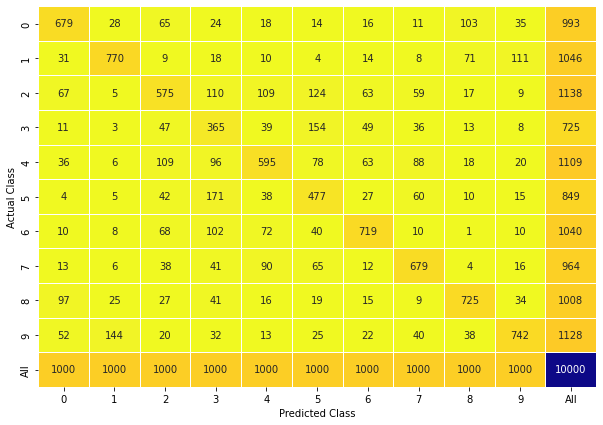

In [84]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from datetime import datetime

def build_confusion_matrix(model, dataloader, labelClasses=[0,1,2,3,4,5,6,7,8,9]):
    ''' builds a confusion matrix showing the interaction of the different classes, and distribution of TP and FP between each class.
        model's input shape and output shape needs to match provided dataset input shape and target set respectively.
        produces a matplotlib graph output and saves it to the results folder.
    '''
    from sklearn.metrics import confusion_matrix

    resultsDict = {}
    predictions = []
    results = []
    num_samples = 0
    confidences = []
    accuracies = []
    outputs = []
    results = []
    labels = []
    
     # Iterate over the data loader and collect predictions and ground truth
    for i, (inputs, targets) in enumerate(dataloader):
        print("\rtest evaluation: "+str(i)+" of "+str(len(dataloader)-1),end='')
        inputs = inputs.cuda()
        targets = targets.cuda()

        # Make predictions
        outputs = model(inputs)
        predictions = F.softmax(outputs, dim=1).detach().cpu().numpy()

        # Update calibration metrics
        num_samples += len(targets)
        confidences.extend(predictions[:, 1])
        results.extend(np.argmax(predictions, axis=1))
        labels.extend(targets.cpu().numpy())
        accuracies.extend(targets.cpu().numpy() == np.argmax(predictions, axis=1))
    print("") ## newline for output formatting
    
    for i, labelClass in enumerate(labelClasses):        
        resultsDict[labelClass]={}
                
    # print(confidences)
    # print(accuracies)
    df_pred = pd.DataFrame(predictions)
    # print(df_pred)
    df = pd.DataFrame(list(zip(results, labels,confidences, accuracies)), columns=["prediction","label","confidence","accuracy"])
    print(df.head())
    # print(df.shape)
    
    
    print(len(results))
    print(len(labels))
    df_confusion = pd.crosstab([results], [labels], rownames=['Actual Class'], colnames=['Predicted Class'], margins=True)
    print(df_confusion)
    
    plt.figure(figsize = (10,7))
    sn.heatmap(df_confusion, annot=True,cbar=False,cmap="plasma_r",fmt='d',linewidth=.5)
    print(model.__class__.__name__)
    
    plt.savefig("./results/{}_{}_confusionMatrix.jpg".format(checkpoint.__class__.__name__,datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")))
    print('\nClassification Report\n')
    target_names = []
    for c in labelClasses:
        target_names.append("Class {}".format(c))
    print(target_names)
    print(classification_report(labels, results, target_names=target_names))

#     pred = np.array(pred)
#     labels = np.array(labels)
#     entropy = np.array(entropy)
#     classCount = {}
#     results = pred
#     labelClasses=classes
#     num_outputs=10

#     for labelClass in labelClasses:
#         resultsDict[labelClass] = {j: [] for j in range(num_outputs)}
# #         resultsDict[labelClass] = [0]*num_outputs
#         classCount[labelClass] = 0
    return True

batch_size = 32        
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

build_confusion_matrix(checkpoint, test_loader)

In [55]:
import numpy as np
import pandas as pd

def entropyConfusionMatrix(pred, labels, entropy, num_outputs, classes, output_names=[]):
    """ generate a matrix of entropy values for all classes and outputs
        pred: list of all predicted labels
        labels: list of all actual labels. must match pred in size and shape
        classes: list of all classes, for example [0,1,2,3]
        output_names: list of names for each of the outputs. applies names to outputs in the same order as pred and labels.

    """    
#  
    df_confusion = pd.crosstab(pred, labels, rownames=['Actual'], colnames=['Predicted'], margins=True)
    print(df_confusion)
#         print(confusion_matrix(item,transpose_labels[i]))
        
    
    
#         for j, branch in enumerate(item):
#             print("{},{}".format(i, j))
#             if branch == True: 
#             resultsDict[labels[i][j]][j].append(branch)
#         classCount[labels[i][0]] += 1
    # print(classCount)
#     print(resultsDict)
    
#     resultsDict = pd.DataFrame.from_dict(resultsDict,orient="index")
# #     print(resultsDict)
#     for column in resultsDict:
# #         print(df[column])
#         resultsDict[column] = [np.array(x).mean() for x in resultsDict[column].values]
# #     resultsDict = resultsDict.mean(axis=0)
#     renameDict={}
#     for i, name in enumerate(output_names):
#         renameDict[i] = name
#     print("rename:{}".format(renameDict))
#     if len(renameDict) > 0:
#         print("rename!")
#         resultsDict = resultsDict.rename(renameDict,axis ="columns")
#     resultsDict["itemCount"] = pd.Series(classCount)
#     return resultsDict
    return

In [54]:
pred = [[3, 3, 5, 4], ]
entropy = [[0.02117890713197057, 1.7145111565508644, 1.123504928401738, 0.02854453329516289], ]
labels = [[3, 3, 3, 3],]
y = entropyConfusionMatrix(pred, labels, entropy, 1,[0,1,2,3,4,5,6,7,8,9])
print(y)

Predicted  3  All
Actual           
3          2    2
4          1    1
5          1    1
All        4    4
None


In [36]:
x= [1,2,3]
y = [4,5,6]

df = pd.DataFrame(list(zip(x,y)),columns=["x","y"])
print(df.head())

   x  y
0  1  4
1  2  5
2  3  6


In [45]:
x = [[0.103248,  0.099111,  0.102926 , 0.091769 , 0.092161  ,0.099890,  0.104131, 0.091169,  0.105975 , 0.109620],]
y = x[:, 1]
print(y)

TypeError: list indices must be integers or slices, not tuple